# Batch analysis 



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display
#import shap
from tqdm.notebook import tqdm

tf.random.set_seed(1234)

# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

In [ ]:
df = og_df.dropna(axis=1, how='all')
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)
  
first_column = df.pop('SE1')
df.insert(1, 'SE1', first_column)

test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]
dates = df.pop('Date')
# df = df.iloc[:,0:5]
print(df.shape)

n_features = df.shape[1]
print(n_features)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

In [3]:

# Split the dataset into training and testing sets
test_size = int(len(df) * 0.05)
val_size = int(len(df) * 0.1)
val_end = test_end - test_size

train_df = df[:val_end-val_size]
val_df = df[val_end-val_size:val_end]
test_df = df[test_end-test_size:test_end]
train_df = pd.concat([train_df, df[test_end:]])


In [4]:
train_df = train_df.to_numpy()
# print(train_df.shape)
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()
X_train = np.reshape(train_df, (train_df.shape[0], 1, train_df.shape[1]))
y_train = train_df[:,0]

#shift the data
X_train = X_train[:-1]
y_train = y_train[1:]

X_val = np.reshape(val_df, (val_df.shape[0], 1, val_df.shape[1]))
y_val = val_df[:,0]

#shift the data
X_val = X_val[:-1]
y_val = y_val[1:]

X_test = np.reshape(test_df, (test_df.shape[0], 1, test_df.shape[1]))
y_test = test_df[:,0]

#shift the data
X_test = X_test[:-1]
y_test = y_test[1:]


In [5]:
batch_size = 128

# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]

# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

In [12]:

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, None, n_features), stateful=True),
    tf.keras.layers.Dense(1)
])

model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(None, n_features)),
    tf.keras.layers.Dense(1)
])

In [7]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric, color='grey')
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric, color='#6db1ff')
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [11]:

def compile_and_fit(model, X_train, y_train, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  model.reset_states()
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=batch_size, verbose=1)
  return history

# Baseline

## Training with batching and 10 epochs

In [9]:
# Set batch size to 128 and rerun sample calculations
batch_size = 128
print(X_train.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
print(X_train.shape)
print(y_train.shape)
# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0
history3 = compile_and_fit(model, X_train, y_train)
result3 = model.predict(X_val, batch_size=batch_size)


(172416, 1, 470)
(172416, 1, 470)
(172416,)
Epoch 1/10
1347/1347 [==============================] - 11s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0573 - val_loss: 3.5619e-04 - val_mean_absolute_error: 0.0151 - val_root_mean_squared_error: 0.0189
Epoch 2/10
1347/1347 [==============================] - 8s 6ms/step - loss: 1.2075e-04 - mean_absolute_error: 0.0068 - root_mean_squared_error: 0.0110 - val_loss: 4.5844e-04 - val_mean_absolute_error: 0.0185 - val_root_mean_squared_error: 0.0214
Epoch 3/10
1347/1347 [==============================] - 8s 6ms/step - loss: 6.3997e-05 - mean_absolute_error: 0.0048 - root_mean_squared_error: 0.0080 - val_loss: 1.6190e-04 - val_mean_absolute_error: 0.0107 - val_root_mean_squared_error: 0.0127
Epoch 4/10
1347/1347 [==============================] - 8s 6ms/step - loss: 5.3194e-05 - mean_absolute_error: 0.0041 - root_mean_squared_error: 0.0073 - val_loss: 6.9875e-05 - val_mean_absolute_error: 0.0069 - val_root_me

## Training with and without batching, 3 epochs

In [13]:
history = compile_and_fit(model, X_train, y_train)


# Set batch size to 1 and rerun sample calculations
batch_size = 1
print(X_train.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
print(X_train.shape)
print(y_train.shape)
# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

history_128 = compile_and_fit(model2, X_train, y_train)




Epoch 1/3
1347/1347 [==============================] - 10s 6ms/step - loss: 0.0047 - mean_absolute_error: 0.0234 - root_mean_squared_error: 0.0687 - val_loss: 4.3846e-04 - val_mean_absolute_error: 0.0171 - val_root_mean_squared_error: 0.0209
Epoch 2/3
1347/1347 [==============================] - 7s 5ms/step - loss: 1.3463e-04 - mean_absolute_error: 0.0071 - root_mean_squared_error: 0.0116 - val_loss: 1.8608e-04 - val_mean_absolute_error: 0.0109 - val_root_mean_squared_error: 0.0136
Epoch 3/3
1347/1347 [==============================] - 7s 5ms/step - loss: 7.5181e-05 - mean_absolute_error: 0.0052 - root_mean_squared_error: 0.0087 - val_loss: 1.3405e-04 - val_mean_absolute_error: 0.0092 - val_root_mean_squared_error: 0.0116
(172416, 1, 470)
(172416, 1, 470)
(172416,)
Epoch 1/3
172416/172416 [==============================] - 689s 4ms/step - loss: 1.4118e-04 - mean_absolute_error: 0.0061 - root_mean_squared_error: 0.0119 - val_loss: 1.4759e-04 - val_mean_absolute_error: 0.0107 - val_root_

## Results

In [14]:
result = model2.predict(X_val, batch_size=batch_size)


# Set batch size to 128 and rerun sample calculations
batch_size = 128

# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0
result2 = model.predict(X_val, batch_size=batch_size)

158/158 [==============================] - 1s 3ms/step


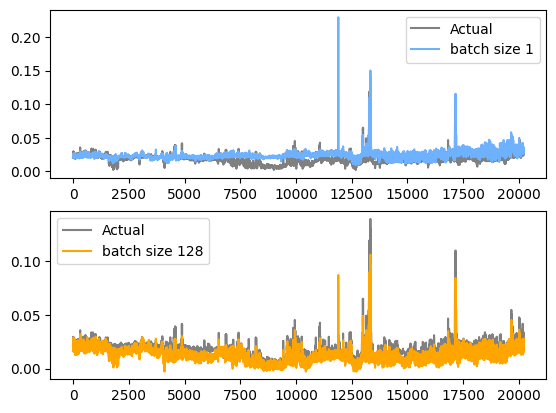

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(y_val, label='Actual', color='grey')
ax1.plot(result, label='batch size 1', color='#6db1ff')
ax1.legend()
ax2.plot(y_val, label='Actual', color='grey')
ax2.plot(result3, label='batch size 128', color='orange')
ax2.legend()
